In [1]:
%load_ext autoreload
%autoreload 2

import requests
import torch
from torch.utils.data import DataLoader
import random
import torch.nn as nn 
from torch import optim
# from sklearn.decomposition import TruncatedSVD as svds
from scipy.sparse.linalg import svds
from sklearn.preprocessing import normalize
from torch.nn.utils.rnn import pad_sequence
from spice import SpiceEmbeddingModel
from gru import GRUEncoder, GRUDecoder
from matplotlib import pyplot as plt
from time import time 
import spice

# Spice encoding 

In [2]:


URL = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
FILE_PATH = "shakespeare.txt"
EMB_DIM = 64
WINDOW = 5



try:
    with open(FILE_PATH, 'r', encoding='utf-8') as f:
        text = f.read()
except FileNotFoundError:
    response = requests.get(URL)
    text = response.text
    with open(FILE_PATH, 'w', encoding='utf-8') as f:
        f.write(text)


# Modèle definition

Epoch 1/70, Loss: 0.008361235364149748
Epoch 2/70, Loss: 0.008020701275778596
Epoch 3/70, Loss: 0.007770651008203541
Epoch 4/70, Loss: 0.007441393242598596
Epoch 5/70, Loss: 0.007082269038867459
Epoch 6/70, Loss: 0.00680939670895565
Epoch 7/70, Loss: 0.006541671073963781
Epoch 8/70, Loss: 0.006229890519700182
Epoch 9/70, Loss: 0.0059456592372787945
Epoch 10/70, Loss: 0.005665215901734138
Epoch 11/70, Loss: 0.005448012256899595
Epoch 12/70, Loss: 0.005202508135963316
Epoch 13/70, Loss: 0.00496624384091278
Epoch 14/70, Loss: 0.00473070480670272
Epoch 15/70, Loss: 0.004565175747054375
Epoch 16/70, Loss: 0.004399551053542051
Epoch 17/70, Loss: 0.0042313244359155015
Epoch 18/70, Loss: 0.00409700935547748
Epoch 19/70, Loss: 0.003963966612487143
Epoch 20/70, Loss: 0.0038295774065773003
Epoch 21/70, Loss: 0.0037398037225516005
Epoch 22/70, Loss: 0.00361746038172648
Epoch 23/70, Loss: 0.0035108838710584678
Epoch 24/70, Loss: 0.0034073707469029946
Epoch 25/70, Loss: 0.003331974808878096
Epoch 26

[]

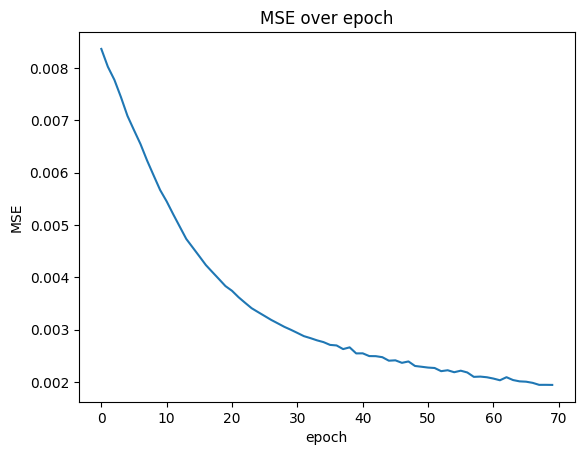

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = 50 # taille des embeddings
hidden_size = 128
lr = 0.001
num_layer=7
num_epochs = 70
batch_size = 64
role_dim=20

spice_model = SpiceEmbeddingModel(emb_dim=input_size, window_size=3)
spice_model.load_model()
dataset = spice_model.get_dataset(text, role_dim=role_dim)
spice_model.save_model()

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=spice.collate_fn_fillers_roles)

encoder = GRUEncoder(input_size, hidden_size, num_layer).to(device)
decoder = GRUDecoder(hidden_size, input_size, num_layer).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(list(encoder.parameters()) +list(decoder.parameters()), lr=lr)

losses = []
t0 = time()
for epoch in range(num_epochs):
    total_loss = 0.0

    for fillers, roles, lengths in dataloader:
        fillers = fillers.to(device)  # (batch, seq_len, input_size)

        lengths = lengths.to(device)    # (batch,)
        optimizer.zero_grad()

        encoded, perm_idx = encoder(fillers, lengths)
        reconstructed = decoder(encoded, lengths)
        
        # remettre les séquences dans l'ordre original
        _, reverse_idx = perm_idx.sort()
        reconstructed = reconstructed[reverse_idx]
        fillers = fillers[reverse_idx]


        loss = criterion(reconstructed, fillers)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    losses.append(total_loss/ len(dataloader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(dataloader)}")
t1 = time()
torch.save(encoder, "encoder.pth")
torch.save(decoder, "decoder.pth")
print( f"training time : {t1-t0}")
plt.plot(losses)
plt.title("MSE over epoch")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.plot()


In [21]:


def decode_sequence(spice_model, sequence):
    """decode les embeddings en mots"""
    decoded_words = []
    for embedding in sequence.cpu():
        if embedding.sum() != 0:  # ignorer le padding pour récupérer la taille de la vrai séquence
            decoded_words.append(spice_model.decode_embedding(embedding.detach().numpy(), top_n=1)[0])
    return " ".join(decoded_words)

fillers, roles, lengths = next(iter(dataloader))  
idx = random.randint(0, fillers.size(0) - 1)  #  phrase au hasard
input_seq = fillers[idx].unsqueeze(0).to(device)  # le tenseur avec du padding
mask = (input_seq != 0).any(dim=2)  # vérifie si chaque ligne contient des valeurs non nulles
tensor_clean = input_seq[:, mask[0], :] # enlève les vecteurs nuls du padding
length = torch.tensor([tensor_clean.shape[1]]).to(device)  # récupère la longueur originale sans le padding


encoder.eval()
decoder.eval()
with torch.no_grad():
    encoded, _ = encoder(input_seq, length)
    reconstructed_seq = decoder(encoded, length)


original_text = decode_sequence(spice_model, input_seq.squeeze(0))
reconstructed_text = decode_sequence(spice_model, reconstructed_seq.squeeze(0))


print(f"originale**: {original_text}")
print(f"reconstruite**: {reconstructed_text}")


originale**: give me the glass and therein will i read
reconstruite**: give me the like and make old thus not


# test
